In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from utils import *

Populating the interactive namespace from numpy and matplotlib


# Jumper

In [2]:
# load train and test data
train_PV = np.load('./data/Running/jumper_after_run/wr112_0905_train_PV.npy')
train_pos = np.load('./data/Running/jumper_after_run/wr112_0905_train_pos.npy')
test_PV = np.load('./data/Running/jumper_after_run/wr112_0905_test_PV.npy')
test_pos = np.load('./data/Running/jumper_after_run/wr112_0905_test_pos.npy')

In [3]:
train_PV.shape, train_pos.shape, test_PV.shape, test_pos.shape

((5044, 3400), (5044, 2), (2161, 3400), (2161, 2))

In [4]:
neuron_idx = np.load('./data/Jumper/wr112_0905_place_units_id.npy')

In [5]:
test_PV.reshape(-1, 50, neuron_idx.shape[0]).shape

(2161, 50, 68)

In [6]:
X = train_PV.reshape(-1, 50, neuron_idx.shape[0])
X.shape

(5044, 50, 68)

In [7]:
# X[:, :45, :] = 0

In [8]:
train_PV = X.reshape(train_PV.shape[0], -1)

In [9]:
train_PV.shape

(5044, 3400)

In [10]:
# initiate model
decoder = DeepOSC(input_dim = train_PV.shape[1], output_dim = 2)

In [56]:
# decoder.fit feed both training data and test data, and will return the training loss and test r2 score for cross validation
# Moniter the test r2 score as an indicator of the model generalization under noise, when it approach 0.8 means learns to estimate the location from PV
# make sure use ways to trigger the KeyboardInterrupt to stop training (for example, click stop button), as we want to enable the running stats after training
try:
    decoder.disable_running_stats()
    decoder.fit(train_PV, train_pos, test_PV, test_pos, max_noise=1.5, lr=3e-4)
except KeyboardInterrupt:
    print(f'\nTraining stopped by user')
    decoder.enable_running_stats(reset=True)

[70] loss: 16.251, test r2: 0.827, std:0.537, norm_h:1.265, norm_output:9.242
Training stopped by user


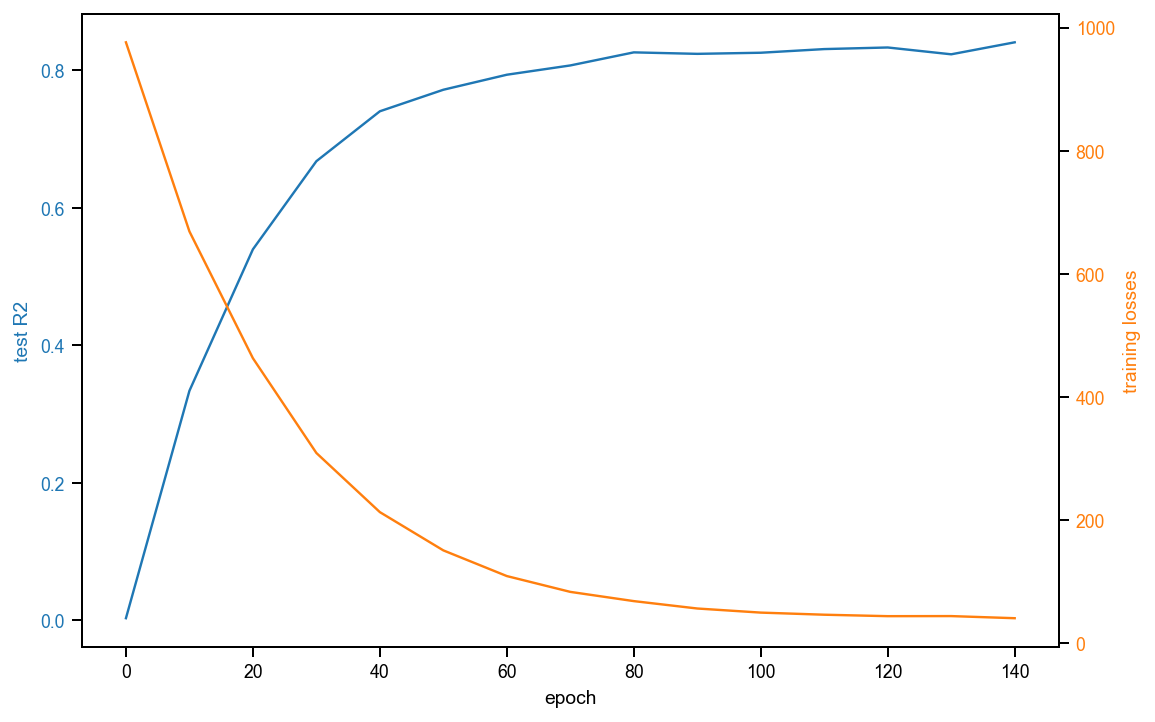

In [80]:
# plot training loss, and test r2 score
# as the model never trained on the test data, the test r2 score is a good indicator of the model generalization
decoder.plot_loss();

In [58]:
pv = np.load('./data/Jumper/wr112_0905_Jumper_PV.npy')
pv_t = np.load('./data/Jumper/wr112_0905_Jumper_PV_t.npy')
dec_pos = np.load('./data/Jumper/wr112_0905_Jumper_dec_pos.npy')

In [59]:
pv.shape[0], pv_t.shape[0], dec_pos.shape[0], pv.shape[0] - dec_pos.shape[0]

(19317, 19317, 19268, 49)

In [60]:
B_bins = 50
X = pv_2_spv(pv, B_bins=B_bins)
X.shape

(19268, 50, 157)

In [61]:
@interact(i = (B_bins, X.shape[0]-1))
def visualiz_pv(i=B_bins-1):
    fig, ax = plt.subplots(1, 1, figsize=(X.shape[2]//20, X.shape[1]//20))
    ax.imshow(X[i], aspect='auto', cmap=neo)
    ax.set_xlabel('place units')
    ax.set_ylabel('time bins')
    plt.show();

interactive(children=(IntSlider(value=50, description='i', max=19267, min=50), Output()), _dom_classes=('widge…

In [62]:
redec_pos = decode(decoder.model, X, neuron_idx, cuda=True, mimic_realtime=False)

IndexError: index 159 is out of bounds for axis 2 with size 157

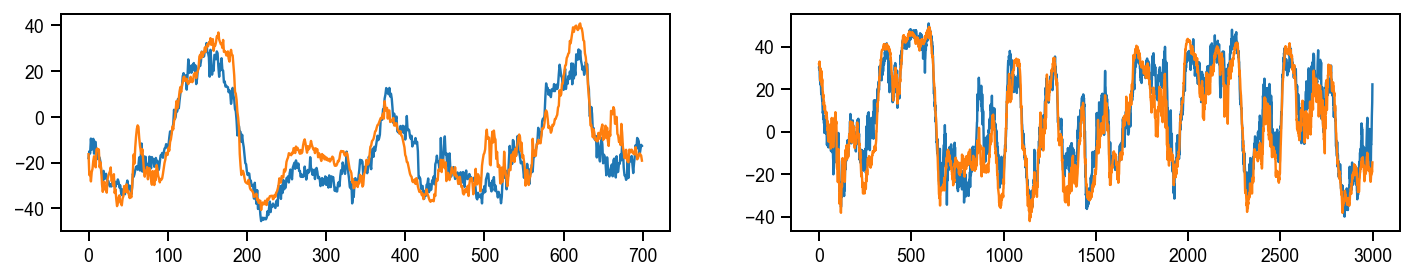

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,2))
ax[0].plot(redec_pos[2500:3200, 0]);
ax[0].plot(dec_pos[2500:3200, 0]);
ax[1].plot(redec_pos[-3000:, 0]);
ax[1].plot(dec_pos[-3000:, 0]);

In [37]:
# how similar is the result to the online decoding result? Very similar!
r2_score(gaussian_filter1d(redec_pos, 10), gaussian_filter1d(dec_pos, 10))

0.7708802597485801

In [13]:
# torch.save(model.model.state_dict(), './pretrained_model/retrain/wr112_0905_offline_model.pth')

# Jedi

Jedi training is a little different from Jumper in terms of the training set is reconstruct through a factor analysis (40 dimension used) to ensure the backbone of data is on-manifold (read our paper for detail)
However, the test data is still population vector of spiking data of place units. Here will visualize the test data. It is only fair to use PV of spiking data to test decoder as in real-time setup, there is no factor analysis involved. The real-time input for Jumper, Jedi and test data is the same: PV of spiking data of place units.

In [43]:
# load train and test data
train_PV = np.load('./data/Running/jedi_after_run/wr112_0901_train_FA40_PV.npy')
train_pos = np.load('./data/Running/jedi_after_run/wr112_0901_train_pos.npy')
test_PV = np.load('./data/Running/jedi_after_run/wr112_0901_test_FA40_PV.npy')
test_pos = np.load('./data/Running/jedi_after_run/wr112_0901_test_pos.npy')

In [44]:
# load train and test data
# train_PV = np.load('./data/Running/jedi_after_run/wr118_0829_train_FA40_PV.npy')
# train_pos = np.load('./data/Running/jedi_after_run/wr118_0829_train_pos.npy')
# test_PV = np.load('./data/Running/jedi_after_run/wr118_0829_test_FA40_PV.npy')
# test_pos = np.load('./data/Running/jedi_after_run/wr118_0829_test_pos.npy')

In [45]:
train_PV.shape, train_pos.shape, test_PV.shape, test_pos.shape

((6261, 5500), (6261, 2), (2683, 5500), (2683, 2))

In [46]:
neuron_idx = np.load('./data/Jedi/wr112_0901_place_units_id.npy')

In [47]:
test_PV.reshape(-1, 50, neuron_idx.shape[0]).shape

(2683, 50, 110)

In [48]:
X = test_PV.reshape(-1, 50, neuron_idx.shape[0])
B_bins=50

In [49]:
@interact(i = (B_bins, X.shape[0]-1))
def visualiz_pv(i=B_bins-1):
    fig, ax = plt.subplots(1, 1, figsize=(X.shape[2]//20, X.shape[1]//20))
    ax.imshow(X[i], aspect='auto', cmap=neo)
    ax.set_xlabel('place units')
    ax.set_ylabel('time bins')
    plt.show();

interactive(children=(IntSlider(value=50, description='i', max=2682, min=50), Output()), _dom_classes=('widget…

In [63]:
X = train_PV.reshape(-1, 50, neuron_idx.shape[0])
X.shape

(6261, 50, 110)

In [64]:
# X[:, :45, :] = 0

In [65]:
train_PV = X.reshape(train_PV.shape[0], -1)

In [66]:
train_PV.shape

(6261, 5500)

In [67]:
# initiate model
decoder = DeepOSC(input_dim=train_PV.shape[1], output_dim=2)

In [69]:
try:
    decoder.disable_running_stats()
    decoder.fit(train_PV, train_pos, test_PV, test_pos, max_noise=1.5, lr=3e-4)
except KeyboardInterrupt:
    print(f'\nTraining stopped by user')
    decoder.enable_running_stats(reset=True)

[140] loss: 39.915, test r2: 0.841, std:1.003, norm_h:1.288, norm_output:9.699
Training stopped by user


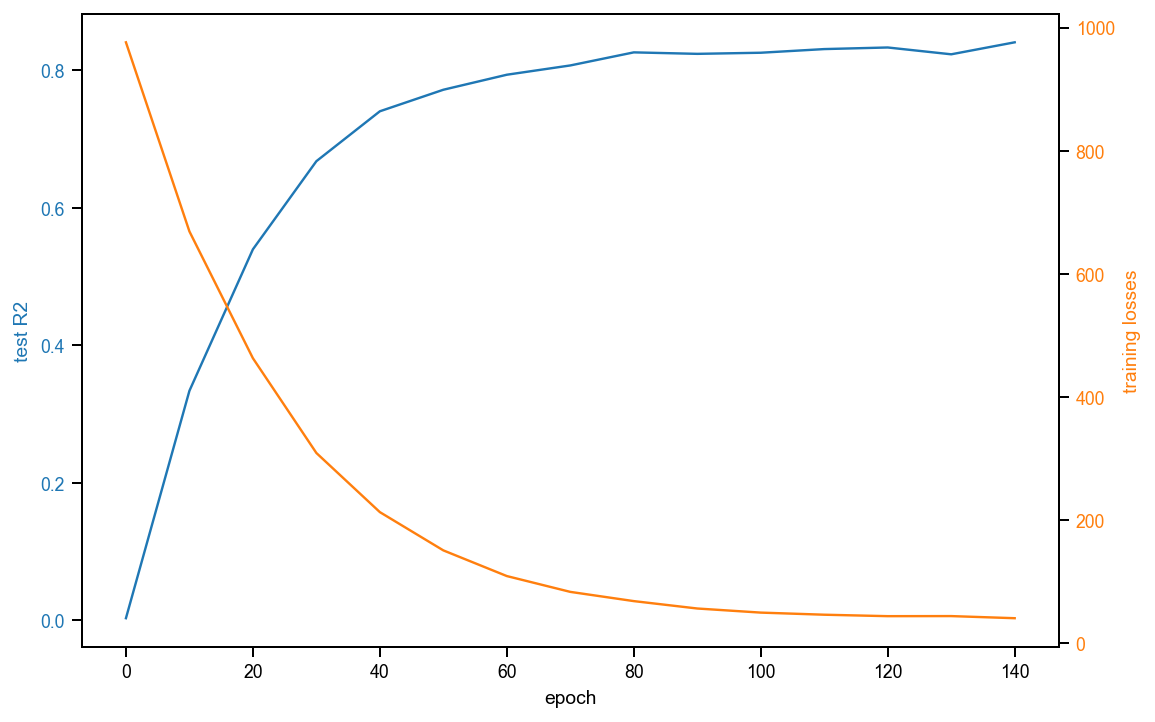

In [70]:
decoder.plot_loss();

In [71]:
B_bins = 50
pv = np.load('./data/Jedi/wr112_0901_JEDI_PV.npy')
pv_t = np.load('./data/Jedi/wr112_0901_JEDI_PV_t.npy')
dec_pos = np.load('./data/Jedi/wr112_0901_JEDI_dec_pos.npy')

In [72]:
pv.shape, pv_t.shape, dec_pos.shape, pv.shape[0] - dec_pos.shape[0]

((16280, 253), (16280,), (16231, 2), 49)

In [73]:
X = pv_2_spv(pv, B_bins=B_bins, padding=False)
X.shape

(16231, 50, 253)

In [74]:
@interact(i = (B_bins, X.shape[0]-1))
def visualiz_pv(i=B_bins-1):
    fig, ax = plt.subplots(1, 1, figsize=(X.shape[2]//20, X.shape[1]//20))
    ax.imshow(X[i], aspect='auto', cmap=neo)
    ax.set_xlabel('place units')
    ax.set_ylabel('time bins')

interactive(children=(IntSlider(value=50, description='i', max=16230, min=50), Output()), _dom_classes=('widge…

In [75]:
redec_pos = decode(decoder.model, X, neuron_idx, cuda=True, mimic_realtime=False)

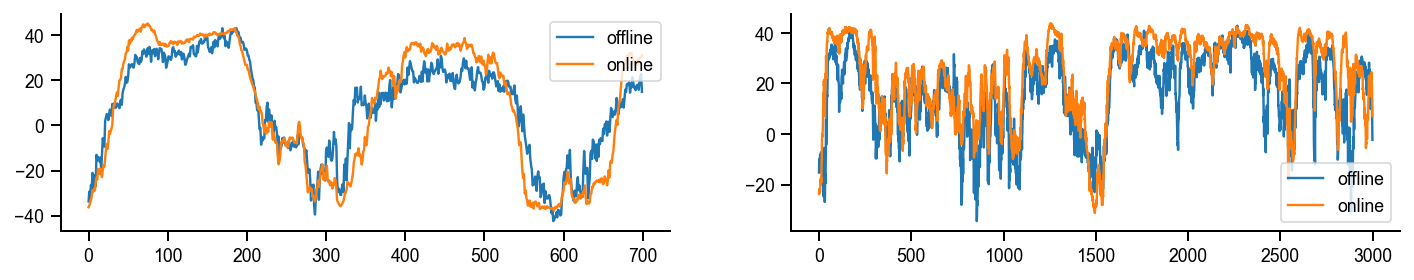

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,2))
ax[0].plot(redec_pos[2500:3200, 0], label='offline');
ax[0].plot(dec_pos[2500:3200, 0], label='online');
ax[1].plot(redec_pos[-3000:, 0], label='offline');
ax[1].plot(dec_pos[-3000:, 0], label='online');
ax[0].legend();
ax[1].legend();
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

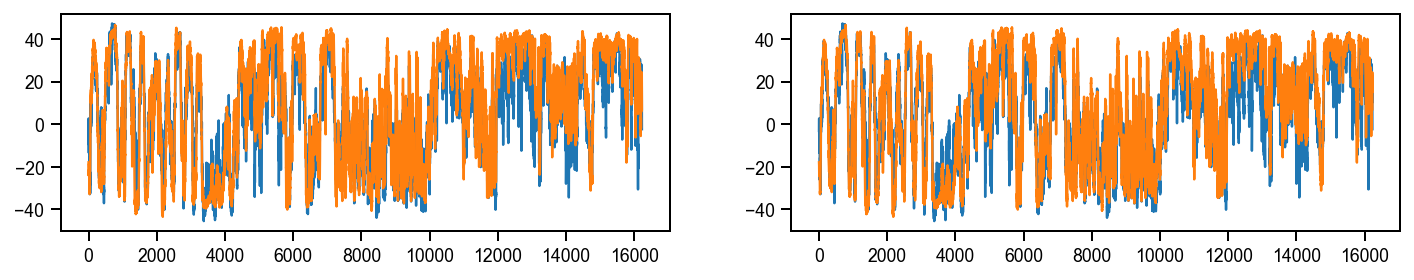

In [77]:
fig, ax = plt.subplots(1,2, figsize=(12,2))
ax[0].plot(redec_pos[:, 0]);
ax[0].plot(dec_pos[:, 0]);
ax[1].plot(redec_pos[:, 0]);
ax[1].plot(dec_pos[:, 0]);

In [79]:
# how similar is the result to the online decoding result? Very similar!
r2_score(gaussian_filter1d(redec_pos, 10), gaussian_filter1d(dec_pos, 10))

0.8531537299244663

In [ ]:
# torch.save(model.model.state_dict(), './pretrained_model/retrain/wr112_0905_offline_model.pth')